In [29]:
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import fsolve

from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import astropy 
from ligo.skymap.io import fits
from ligo.skymap.postprocess import find_greedy_credible_levels

import os
from os import listdir
from os.path import isfile, join

import sys
from tqdm import tqdm
from numba import njit

H0GLOB=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
Planck18


        Use get instead. [ligo.skymap.postprocess.cosmology]


FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

In [2]:
def get_ename(fname, verbose=True):

        if len(fname.split('/')[-1].split('_')) <= 2:    #Same as before since certain names contain a "_"
            event_name = fname.split('/')[-1].split('_')[0]
        elif len(fname.split('/')[-1].split('_')) > 2:
            event_name = fname.split('/')[-1].split('_')[0]+'_'+fname.split('/')[-1].split('_')[1]
        else:
            raise ValueError('Could not set event name. Got fname= %s'%fname)
        if verbose:
            print('-- %s' %event_name)
        return event_name
    
def find_ra_dec(nside, pix):
        '''
        input:  pixel ra dec in degrees
        output: (ra, dec) of pixel center in degrees, with nside given by that of the skymap 
        '''
        theta, phi =find_theta_phi(nside,pix)
        ra, dec = ra_dec_from_th_phi(theta, phi)
        return ra, dec    
    
def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
    
def find_theta_phi(nside, pix):
        '''
        input:  pixel
        output: (theta, phi)of pixel center in rad, with nside given by that of the skymap 
        '''
        return hp.pix2ang(nside, pix, nest=True)
    
def _read_O3( fname, convert_nested=True):
        
        skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        event_name = get_ename(fname, verbose=True)
        print('Event: %s' %event_name)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            p_posterior = hp.reorder(skymap[0],n2r=True)
            mu = hp.reorder(skymap[1],n2r=True)
            sigma = hp.reorder(skymap[2],n2r=True)
            posteriorNorm = hp.reorder(skymap[3],n2r=True)
            print('convertito da nested a ring')
            mu_avr=np.average(mu,weights=p_posterior)
            print('average luminosity distance={} Mpc'.format(mu_avr))
            sig_avr=np.average(sigma,weights=p_posterior)
            print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
            Norm_avr=np.average(posteriorNorm,weights=p_posterior)
            print('average posteriorNorm={} Mpc'.format(Norm_avr))
            z_gw=z_from_dL(mu_avr)
        else:
            p_posterior= skymap[0]
            mu= skymap[1]
            sigma = skymap[2]
            posteriorNorm= skymap[3]        
        npix = len(p_posterior)
        nside=hp.npix2nside(npix)
        theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
        print('Theta={}, Phi={}'.format(theta, phi))
        ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
        print('Right Ascension={}, Declination={}'.format(ra, dec))
        mu_avr=np.average(mu,weights=p_posterior)
        print('average luminosity distance={} Mpc'.format(mu_avr))
        sig_avr=np.average(sigma,weights=p_posterior)
        print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
        Norm_avr=np.average(posteriorNorm,weights=p_posterior)
        print('average posteriorNorm={}'.format(Norm_avr))
        #print(metadata)
        #dl=metadata['distmean']
        #std=metadata['diststd']
        #z=cosmoglob.H(0).value*dl/clight
        #sigz=cosmoglob.H(0).value*std/clight
        #print('dL={}Mpc, std={}Mpc'.format(dl,std))
        #print('z={}, delta_z={}'.format(z,sigz))
        #print('\n')
        head = None
def z_from_dL(dL_GW_val):
    '''
    Returns redshift for a given luminosity distance dL_GW_val (in Mpc)
    
    Input:
        - dL_GW_val luminosity dist in Mpc
        - H0
        - Xi0: float. Value of Xi_0
        - n: float. Value of n

    '''   
    #print(cosmo.H0)
    func = lambda z : cosmoflag.luminosity_distance(z).value - dL_GW_val
    z = fsolve(func, 1)
    return z[0]

def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.77)
    return z[0]

def mygaussint(prov_mu,prov_sigma,rho=1):
    first=np.exp(-(prov_mu**2)/(2*prov_sigma**2))*prov_mu*rho*prov_sigma/np.sqrt(2*np.pi)
    factor=0.5*rho*(prov_mu**2+prov_sigma**2)
    second=(1+scipy.special.erf(prov_mu/(np.sqrt(2)*prov_sigma)))
    ret=first+factor*second
    return ret
@njit
def sphere_uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    #meanvec=(mux,muy)
    meanvec=np.asarray((np.sin(mux)*np.cos(muy),np.sin(mux)*np.sin(muy),np.cos(mux)))
    norm=np.sqrt(np.sum(meanvec**2))
    meanvec=meanvec/norm
    
    #var=(x,y)
    var=np.asarray((np.sin(x)*np.cos(y),np.sin(x)*np.sin(y),np.cos(x)))
    #norm=np.sqrt(np.dot(var,var))
    norm=np.sqrt(np.sum(var**2))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.sum(diff**2))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    #ret=np.exp(-1/2*(xfactor+yfactor))
    return ret
def sphere_uncorr_gauss_hp(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    #meanvec=(mux,muy)
    meanvec=hp.ang2vec(mux,muy)
    #meanvec=np.asarray((1,mux,muy))
    norm=np.sqrt(np.sum(meanvec**2))
    meanvec=meanvec/norm
    
    #var=(x,y)
    var=hp.ang2vec(x,y)
    #var=np.asarray((1,x,y))
    #norm=np.sqrt(np.dot(var,var))
    norm=np.sqrt(np.sum(var**2))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.sum(diff**2))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    #ret=np.exp(-1/2*(xfactor+yfactor))
    return ret

@njit
def Mises_Fisher(theta,phi,DS_theta,DS_phi,conc):
    meanvec=hp.ang2vec(DS_theta,DS_phi)
    meanvec=np.asarray(meanvec,dtype=np.float128)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(theta,phi)
    var=np.asarray(var,dtype=np.float128)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    factor=np.dot(conc*var,meanvec)
    factor=np.float128(factor)
    #Normalization is futile, we will devide by the sum
    #fullnorm=conc/(2*np.pi*(np.exp(conc)-np.exp(-conc)))
    ret=np.float128(np.exp(factor))#/fullnorm
    #ret=factor
    return ret

def N_i(mu,sigma):
    #Visto che usiamo pochi valori di sigma, puoi anche sostituire
    #la formula generale con il valore numerico calcolato con Mathematica
    q1=0.5*(mu**2 + sigma**2)
    q2=1+scipy.special.erf(mu/(np.sqrt(2)*sigma))
    q3=np.exp(-(mu**2)/(2*(sigma**2) ))*mu*sigma
    q4=1/(np.sqrt(2*np.pi))
    ret= q3/q4 + q1*q2
    return ret

In [3]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/Hold_O3/'
os.chdir(GW_data_path)
#all_event=os.listdir()

  # Function to exploit, find how to localise an event and produce a proxy one. 
   def _read_O3(self, fname, convert_nested=True):
        
   skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        self.event_name = get_ename(fname, verbose=self.verbose)
        if self.verbose:
                print('\nEvent: %s' %self.event_name)
                #Raul: prints for control
                print('Delta=%s. If delta=1, normal run '%delta)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            self.p_posterior = hp.reorder(skymap[0],n2r=True)
            self.mu = hp.reorder(skymap[1],n2r=True)
            self.sigma = hp.reorder(skymap[2],n2r=True)*delta
            self.posteriorNorm = hp.reorder(skymap[3],n2r=True)
        else:
            self.p_posterior= skymap[0]
            self.mu= skymap[1]
            self.sigma = skymap[2]*delta
            self.posteriorNorm= skymap[3]    

In [4]:
#Some files to look at 
filenames=['GW190814_PublicationSamples.fits'
           #,'GW190924_021846_PublicationSamples.fits'
           #,'GW190412_PublicationSamples.fits'
           #,'GW190915_235702_PublicationSamples.fits',
           #'GW190708_232457_PublicationSamples.fits',
           #'GW190421_213856_PublicationSamples.fits',
           #,'GW190527_092055_PublicationSamples.fits' 
           ]
########################## THIS GIVE US SOME INFO ######################################
#for name in filenames:
#    _read_O3(name)
########################################################################################
fname ='GW190814_PublicationSamples.fits'
alldl=[]
allsig=[]
for fname in filenames:
    print(fname)
    skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
    p_posterior= skymap[0]
    mu= skymap[1]
    sigma = skymap[2]
    posteriorNorm= skymap[3]        
    npix = len(p_posterior)
    print('npix={}'.format(npix))
    nside=hp.npix2nside(npix)
    print('nside={}'.format(nside))
    theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
    ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
    print('RA={},dec={},theta={},phi={}'.format(ra,dec,theta,phi))
    alldl.append(mu[np.argmax(p_posterior)])
    print('Dl={}'.format(mu[np.argmax(p_posterior)]))
    sig_avr=np.average(sigma,weights=p_posterior)
    allsig.append(sig_avr)
    print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
    #print(len(p_posterior))
#alldl=np.asarray(alldl)
#print(np.mean(alldl))

GW190814_PublicationSamples.fits
npix=12582912
nside=1024
RA=12.7001953125,dec=-24.87076339473571,theta=2.004873035517517,phi=0.22166022384947515
Dl=235.45665178530027
average luminosity distance Sigma=26.530261090991182 Mpc


In [5]:
sig_perc=[]
for i in range(len(alldl)):
    sig_perc.append(100*allsig[i]/alldl[i])
sig_perc=np.asarray(sig_perc[0:-1])
print(np.mean(sig_perc))

nan


/home/rciancarella/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rciancarella/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
my_theta,my_phi=hp.pix2ang(nside, np.argmax(p_posterior), nest=True)
vec = hp.ang2vec(my_theta, my_phi)
my_maxpix=hp.ang2pix(nside, my_theta, my_phi,nest=True)
maxpix=np.argmax(p_posterior)
print(maxpix,my_maxpix)

In [ ]:
print(vec)

In [ ]:
hp.mollview(p_posterior, title=fname,nest=True)

In [ ]:
credible_levels = find_greedy_credible_levels(p_posterior)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))

In [ ]:
_read_O3(fname)

In [ ]:
vec = hp.ang2vec(my_theta, my_phi)
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
ipix_90 = hp.query_disc(nside=nside, vec=vec, radius=np.radians(radius_deg), nest=True)
m =np.zeros(len(p_posterior))
m[ipix_disc] = 1/len(ipix_disc)
hp.mollview(m, title="Gaussian Mask",nest=True)

In [ ]:
Mock_Area_deg=len(ipix_disc) * hp.nside2pixarea(nside, degrees=True)
Mock_Area_90_deg=len(ipix_90) *hp.nside2pixarea(nside, degrees=True)
print('99.9999% area is {} squared deg\n90% area is {} squared deg'.format(Mock_Area_deg,Mock_Area_90_deg))

In [ ]:
'''
https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html(for ref on skymap)

Now we need to rescale the probability. We set the prob=0 ouside the circle
We assume that the renormalization is constant.
We crate a mask with our circle. Outside the mask p_posterior=0, the renormalization
constan alpha, is therefore 1/sum(p_posterior()). This ensure unitarity. 

If this works, than we will use a 2D Gaussian distribution for the probability

'''


GW190512_180714_PublicationSamples.fits


9.986854087797142e-07

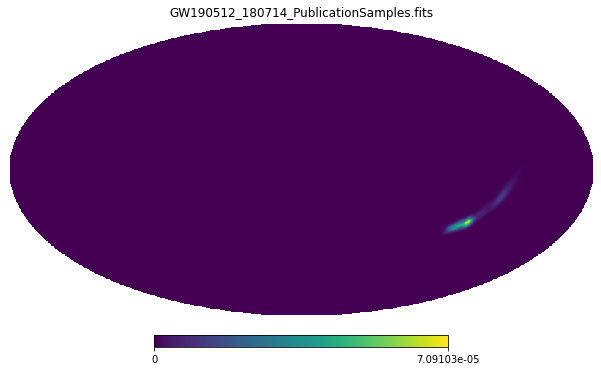

In [97]:
fname ='GW190512_180714_PublicationSamples.fits'
print(fname)
skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
p_posterior= skymap[0]
mu= skymap[1]
sigma = skymap[2]
posteriorNorm= skymap[3]        
npix = len(p_posterior)
nside=hp.npix2nside(npix)
all_pixels=np.arange(npix)
hp.mollview(p_posterior, title=fname,nest=True)
hp.nside2pixarea(nside)

In [102]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(p_posterior))
my_ra, my_dec=find_ra_dec(nside,np.argmax(p_posterior))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mutmp=mu[myidx]
ptmp=p_posterior[myidx]
pxmask = np.isfinite(mutmp) & (mutmp >= 0)
print(pxmask,len(pxmask))
mu_avr=np.average(mutmp[pxmask],weights=ptmp[pxmask])
print('average luminosity distance={} Mpc; Distance from metadata {} Mpc'.format(mu_avr,metadata['distmean']))

GW location: theta=2.0352301478699384, phi=4.366476312716477, RA=250.18066406249997, DEC=-26.610097810733922
[ True  True  True ...  True  True  True] 69008
average luminosity distance=1270.5684715395284 Mpc; Distance from metadata 1462.46170897 Mpc


In [67]:
print(np.isinf(p_posterior).all())
print(np.isnan(p_posterior).all())

False
False


In [69]:
for i in range(len(p_posterior)):
    if mu[i] is None:
        print(i)

In [65]:
metadata.keys()

odict_keys(['HISTORY', 'gps_time', 'gps_creation_time', 'creator', 'origin', 'distmean', 'diststd', 'vcs_version', 'nest'])

# Prova selezione pix 90%

In [ ]:
    def compute_sky_conf_event(event, nside):
        """Return all the Healpix pixel indices where the probability of an event is above a given threshold.

        Args:
            event (int): number of the event
            nside (int): nside parameter for Healpix

        Returns:
            np.ndarray: Healpix indices of the skymap where the probability of an event is above a given threshold.
        """

        pixel_key      = f"pix{nside}"
        unique, counts = np.unique(self.data[pixel_key][event], return_counts=True)
        p              = np.zeros(hp.nside2npix(nside), dtype=float)
        p[unique]      = counts/self.data[pixel_key][event].shape[0]

        return np.argwhere(p >= self._get_threshold(p, level=self.sky_conf)).flatten()

In [14]:
    def _get_threshold(norm_counts, level=0.9):
        '''
        Finds value mincount of normalized number counts norm_counts that bouds the x% credible region , with x=level
        Then to select pixels in that region: all_pixels[norm_count>mincount]
        '''
        prob_sorted     = np.sort(norm_counts)[::-1]
        prob_sorted_cum = np.cumsum(prob_sorted)
        idx             = np.searchsorted(prob_sorted_cum, level) # find index of array which bounds the confidence interval
        mincount        = prob_sorted[idx] 
        return mincount

In [28]:
    def My_compute_sky_conf_event(event,ProbLevel=0.9):
        print(event)
        skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
        p_posterior= skymap[0]
        mu= skymap[1]
        sigma = skymap[2]
        posteriorNorm= skymap[3]        
        npix = len(p_posterior)
        nside=hp.npix2nside(npix)
        """Return all the Healpix pixel indices where the probability of an event is above a given threshold.

        Args:
            event (int): number of the event
            nside (int): nside parameter for Healpix

        Returns:
            np.ndarray: Healpix indices of the skymap where the probability of an event is above a given threshold.
        """

        pixel_key      = f"pix{nside}"
        unique, counts = np.unique(all_pixels, return_counts=True)
        #print(unique)
        p              = np.zeros(hp.nside2npix(nside), dtype=float)
        p[unique]      = counts/all_pixels.shape[0]

        return np.argwhere(p >=_get_threshold(p, level=ProbLevel)).flatten()

In [29]:
test=My_compute_sky_conf_event(fname)

GW190512_180714_PublicationSamples.fits
[       0        1        2 ... 12582909 12582910 12582911]


In [30]:
print(test)

[       0        1        2 ... 12582909 12582910 12582911]


In [36]:
    def area(nside,all_pixels,p_posterior,level=0.9):
        
        ''' Area of level% credible region, in square degrees.
            If level is not specified, uses current selection '''
        pixarea=hp.nside2pixarea(nside)
        return get_credible_region_pixels(all_pixels,p_posterior,level=level).size*pixarea*(180/np.pi)**2
            
        
    def _get_credible_region_pth(p_posterior, level=0.9):
        '''
        Finds value minskypdf of rho_i that bouds the x% credible region , with x=level
        Then to select pixels in that region: self.all_pixels[self.p_posterior>minskypdf]
        '''
            
        prob_sorted = np.sort(p_posterior)[::-1]
        prob_sorted_cum = np.cumsum(prob_sorted)
        # find index of array which bounds the self.area confidence interval
        idx = np.searchsorted(prob_sorted_cum, level)
        minskypdf = prob_sorted[idx] #*skymap.npix
        
        #self.p[self.p]  >= minskypdf       
        return minskypdf
    
    def get_credible_region_pixels(all_pixels,p_posterior,level=0.9):
        return all_pixels[p_posterior>_get_credible_region_pth(p_posterior,level=level)]

In [44]:
myarea= area(nside,all_pixels,p_posterior,level=0.999)
print(myarea)
myarea= area(nside,all_pixels,p_posterior,level=0.9)
print(myarea)

2445.70168214534
226.24209323723514


In [98]:
myidx=get_credible_region_pixels(all_pixels,p_posterior,level=0.9)
#print(myidx)

In [92]:
new_allpix=np.zeros(len(p_posterior))
new_allpix[myidx]=p_posterior[myidx]

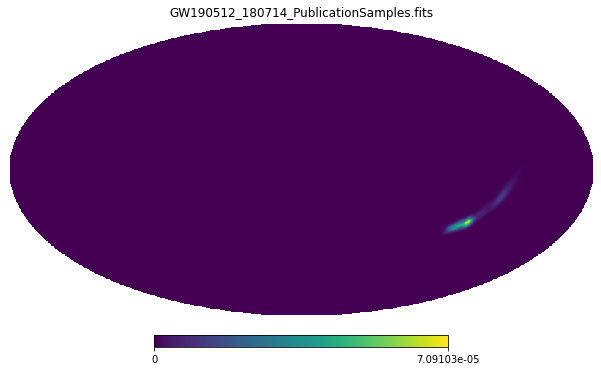

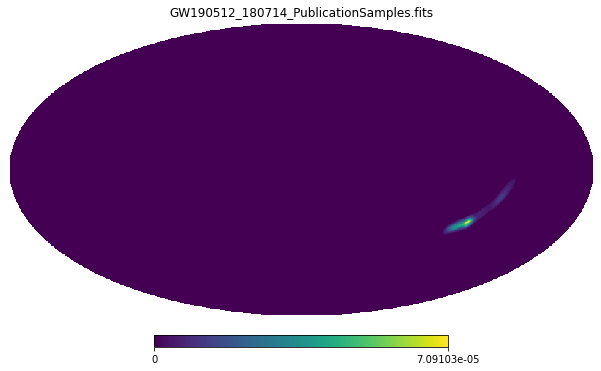

In [93]:
hp.mollview(p_posterior, title=fname,nest=True)
hp.mollview(new_allpix, title=fname,nest=True)

In [149]:
class GWskymap:
    def __init__(self,event,level=None):
       #Costruttore classe
        self.event=event
        self.read_event(event)
        if level==None:
            self.level=0.9
        else:
            self.level=level
        
    def read_event(self,event):
        skymap, metadata = fits.read_sky_map(event, nest=None, distances=True)
        self.p_posterior= skymap[0]
        self.mu= skymap[1]
        self.sigma = skymap[2]
        self.posteriorNorm= skymap[3]        
        self.npix = len(p_posterior)
        self.nside=hp.npix2nside(npix)
        self.metadata=metadata
        #all_pixels=np.arange(npix)
        #return p_posterior,mu,sigma,posteriorNorm,nside,npix,metadata             
    def area(self):
        level=self.level
        nside=self.nside
        ''' Area of level% credible region, in square degrees.
            If level is not specified, uses current selection '''
        pixarea=hp.nside2pixarea(nside)
        return get_credible_region_pixels(all_pixels,p_posterior,level=level).size*pixarea*(180/np.pi)**2
    
    def _get_credible_region_pth(self,p_posterior,level):
        '''
        Finds value minskypdf of rho_i that bouds the x% credible region , with x=level
        Then to select pixels in that region: self.all_pixels[self.p_posterior>minskypdf]
        '''

        prob_sorted = np.sort(self.p_posterior)[::-1]
        prob_sorted_cum = np.cumsum(prob_sorted)
        # find index of array which bounds the self.area confidence interval
        idx = np.searchsorted(prob_sorted_cum, self.level)
        minskypdf = prob_sorted[idx] #*skymap.npix

        #self.p[self.p]  >= minskypdf       
        return minskypdf
    
    def get_credible_region_pixels(self):
        all_pixels=np.arange(self.npix)
        return all_pixels[self.p_posterior>self._get_credible_region_pth(self.p_posterior,self.level)]

In [147]:
DS01=GWskymap(fname)

In [148]:
mypix=DS01.get_credible_region_pixels()

In [158]:
import pprint
pprint.pprint(DS01.metadata)

OrderedDict([('HISTORY',
              ['',
               'Generated by running the following script:',
               'ligo-skymap-from-samples --maxpts 5000 --seed 41 --jobs 1 '
               '--fitsoutname',
               '/home/john.veitch/o3a_catalog_events/o3a_pe_samples_release_uniform_como',
               'ving/GW190512A_PublicationSamples.fits --path '
               'PublicationSamples/posteri',
               'or_samples /local/condor/execute/dir_1954/tmpc594_5d2.h5']),
             ('gps_time', 1241719652.42),
             ('gps_creation_time', 1285506619.072436),
             ('creator', 'ligo-skymap-from-samples'),
             ('origin', 'LIGO/Virgo'),
             ('distmean', 1462.46170897),
             ('diststd', 346.8710515556066),
             ('vcs_version', 'ligo.skymap 0.5.0'),
             ('nest', True)])


In [ ]:

#saved_prob=np.zeros(len(p_posterior))
#saved_prob[ipix_disc]=p_posterior[ipix_disc]
#prob_to_write=np.zeros(len(p_posterior))
#alpha=1/np.sum(saved_prob)
#prob_to_write[ipix_disc]=alpha*saved_prob[ipix_disc]

In [ ]:
#print(np.sum(prob_to_write))

In [ ]:
#hp.mollview(prob_to_write, title="Mollview image NESTED",nest=True)

In [ ]:
#my_sky_tosave=(prob_to_write,skymap[1],sigma,posteriorNorm)
#my_sky_tosave=np.array([prob_to_write,mu,sigma,posteriorNorm])
#dat=Table([prob_to_write,mu,sigma,posteriorNorm],
#          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
#dat.write('Amap.fits',format='fits',overwrite=True)
#fits.write_sky_map('Amap.fits',dat, nest=True)

In [ ]:
#check result

In [ ]:
#my_data,my_meta=fits.read_sky_map("Amap.fits",nest=None, distances=True)
#print(my_meta)

In [ ]:
#hp.mollview(my_data[0], title="Mollview image NESTED",nest=True)

In [ ]:
#print(my_meta)

In [ ]:
#_read_O3('Amap.fits')

In [ ]:
temp_theta,temp_phi=find_theta_phi(nside,np.argmax(gaussmap))
temp_ra, temp_dec=find_ra_dec(nside,np.argmax(gaussmap))
print('GW221005 location: theta={}, phi={}, RA={}, DEC={}'.format(temp_theta,temp_phi,temp_ra,temp_dec))

In [ ]:
fname ='GW221900_PublicationSamples.fits'
my_data,my_meta=fits.read_sky_map(fname,nest=None, distances=True)

In [ ]:
my_prob=my_data[0]
my_mu=my_data[1]
my_sigma=my_data[2]
npix = len(my_prob)
nside=hp.npix2nside(npix)
#my_mu[np.isinf(my_mu)]=0
hp.mollview(my_prob, title=fname,nest=True)

In [ ]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(my_prob))
my_ra, my_dec=find_ra_dec(nside,np.argmax(my_prob))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(my_mu,weights=my_prob)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(my_sigma,weights=my_prob)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

In [ ]:
np.argmax(my_prob)
maxtheta,maxphi=hp.pix2ang(nside, 841536)
vicini=hp.get_all_neighbours(nside,maxtheta,maxphi)
print(maxtheta,maxphi)
print(vicini)

In [ ]:
for i in vicini:
    maxtheta,maxphi=hp.pix2ang(nside, i, nest=True)
    print(hp.get_all_neighbours(nside,maxtheta,maxphi,nest=True))

In [ ]:
if(np.isnan(my_prob).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isnan(my_mu).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
    
if(np.isinf(my_prob).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")
if(np.isinf(my_mu).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

In [ ]:
credible_levels = find_greedy_credible_levels(gaussmap)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))


In [ ]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(my_prob))
my_ra, my_dec=find_ra_dec(nside,np.argmax(my_prob))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(my_mu,weights=my_prob)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(my_sigma,weights=my_prob)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

In [ ]:
np.sum(my_mu[0:3]*my_prob[0:3])

In [ ]:
len(my_mu)==len(my_prob)

# Automatic Map Creator 

z_min=0.7887375950813293, z_max=2.0129446983337402
ra_min=1.558116673550103e-05, ra_max=89.99999237060547
dec_min=2.9646462280652486e-06, dec_max=89.98294830322266
phi_min=2.7194266749575036e-07, phi_max=1.5707961320877075
theta_min=0.0002976218846182377, theta_max=1.570796275052059

In [ ]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [ ]:
nside=512#512#1024
npix = hp.nside2npix(nside)
fisher=0
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)

phi_min=0.0001
phi_max=1.5707961320877075
theta_min=0.0001976218846182377
theta_max=1.570796275052059
phi_start=phi_min+5*sigma_phi
phi_stop=phi_max-5*sigma_phi
step =5* sigma_phi
N=np.floor((phi_stop-phi_start)/step)
N=int(N/2)
#----------------------uniform in comoving DS-----------------------------
zlen=10
allredshift=np.zeros(zlen)
my_zmin=1.1
my_zmax=1.3
my_dcom_min=cosmoflag.comoving_distance(my_zmin).value
my_dcom_max=cosmoflag.comoving_distance(my_zmax).value
alldcom=np.linspace(my_dcom_min,my_dcom_max,zlen)
for i in range(zlen):
    allredshift[i]=z_from_dcom(alldcom[i])
#-------------------------------------------------------------------------
print('Sigma_theta={}, Sigma_phi={}'.format(sigma_theta,sigma_phi))
print('Sigma_theta={}°, Sigma_phi={}°'.format(np.rad2deg(sigma_theta)
                                              ,np.rad2deg(sigma_phi)))
print(step, N)
allphi=np.arange(0,N)*step+phi_start


truethetamin=theta_min+6*sigma_theta
truethetamax=theta_max-6*sigma_theta
M=np.floor((truethetamax-truethetamin)/step)
M=int(M/2)
alltheta=np.arange(0,M)*step+truethetamin

print('N={},M={}, NxM={}'.format(N,M,N*M))


name='GW34xxxx_datasheet.txt'
file= open(name,'w')
my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
file.writelines(my_header)
file.close()

In [ ]:
'''Use this when phi and theta both changes'''
for j in tqdm(range(M)):
    for k in range(N):
        numevent=int(340000)+k+j*N
        fname='GW'+str(numevent)+'_PublicationSamples.fits'
        index=k%zlen
        zref=allredshift[index]
        DS_phi=allphi[k]
        DS_theta=alltheta[j]
        vec = hp.ang2vec(DS_theta, DS_phi)
        ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
        #print(DS_theta,DS_phi)
        if fisher==1:
            gaussmap =np.zeros(npix,dtype=np.float128)
        else:
            gaussmap =np.zeros(npix)
        mod_mu=np.zeros(len(gaussmap))
        mod_sigma=np.zeros(len(gaussmap))
        mod_postnorm=np.zeros(len(gaussmap))
        theta_arr=np.zeros(len(gaussmap))
        phi_arr=np.zeros(len(gaussmap))
        gauss64 =np.zeros(len(gaussmap),dtype=np.float128)

        dlref=cosmoflag.luminosity_distance(zref).value
        dlsig=0.1*dlref
        #print(zref,dlref)
        line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
             str(dlsig)+'\t',str(sigma_phi)+'\n']

        for i in ipix_disc:
            theta,phi=hp.pix2ang(nside,i, nest=True)
            theta_arr[i]=theta
            phi_arr[i]=phi
            gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=False)
            #gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
            mod_mu[i]=dlref#uncorr_gauss(theta,phi)
            mod_sigma[i]=dlsig
            mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
        gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
        #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
        #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]
        
        gauss64=np.float64(gaussmap)
        dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
              names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
        fits.write_sky_map(fname,dat, nest=True)
        with open(name,'a') as f:
            f.writelines(line)

# Generation by extraction from a Galaxy Catalogue

In [ ]:
#----------------Load the catalogue---------------------
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
galcat = pd.read_csv('uniform_comoving_autoconsistent.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
galcat.columns=colnames
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)


In [ ]:
galcat['declination_degrees'].max()

In [ ]:
#----------------------select random hosts ----------------------------------
zmin=1.25
zmax=1.3
Numb_of_DS=300
datasheet='GW97xxxx'
mapnum=970000
source=galcat[galcat['z']>=zmin]
source=source[source['z']<=zmax]
nside=256#1024
npix=hp.nside2npix(nside)
#Best would be to remove the selected one, make them host and then add those again, 
#since we are converting coordinates
#pd.concat([df1, df2, df2]).drop_duplicates(keep=False)

DS_z=np.asarray(source['z'])
DS_dl=np.asarray(source['dl'])
DS_RA=np.asarray(source['right_ascension_degrees'])
DS_DEC=np.asarray(source['declination_degrees'])

phi_gals=np.deg2rad(DS_RA)
theta_gals = (0.5 * np.pi - np.deg2rad(DS_DEC))
#ra_gals=ra = np.rad2deg(phi_gals)
#dec_gals = np.rad2deg(0.5 * np.pi - theta_gals)

#checkRA=DS_RA-ra_gals
#chackDEC=DS_DEC-dec_gals
#print(checkRA)
#print(chackDEC)
fisher=0
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    #conc=50
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)


theta_min=np.min(theta_gals)
theta_max=np.max(theta_gals)
phi_min=np.min(phi_gals)
phi_max=np.max(phi_gals)

truethetamin=theta_min+10*sigma_theta
truethetamax=theta_max-10*sigma_theta
truephimin=phi_min+10*sigma_phi
truephimax=phi_max-10*sigma_phi

trueRA_min=np.rad2deg(truephimin)
trueRA_max=np.rad2deg(truephimax)
trueDECmin=np.rad2deg(-truethetamax+0.5*np.pi)
trueDECmax=np.rad2deg(-truethetamin+0.5*np.pi)

source=source[source['right_ascension_degrees']>=trueRA_min]
source=source[source['right_ascension_degrees']<=trueRA_max]
source=source[source['declination_degrees']>=trueDECmin]
source=source[source['declination_degrees']<=trueDECmax]

cutted=source.sample(Numb_of_DS)

DS_z=np.asarray(cutted['z'])
DS_dl=np.asarray(cutted['dl'])
DS_RA=np.asarray(cutted['right_ascension_degrees'])
DS_DEC=np.asarray(cutted['declination_degrees'])

phi_gals=np.deg2rad(DS_RA)
theta_gals = (0.5 * np.pi - np.deg2rad(DS_DEC))


#print(trueDECmin,trueDECmax,trueRA_min,trueRA_max)

#-------------------DATASHEET--------------------------------------
write=1
if write==1:
    name=datasheet+'_datasheet.txt'
    file= open(name,'w')
    my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
    file.writelines(my_header)
    file.close()
#print(nside,npix) 

In [ ]:
#--------------------Maps Generations-------------------------------
'''Use this when phi and theta both changes'''
for i in tqdm(range(Numb_of_DS)):
    numevent=int(mapnum)+i
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=DS_z[i]
    DS_phi=phi_gals[i]
    DS_theta=theta_gals[i]
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    if fisher==1:
        gaussmap =np.zeros(npix,dtype=np.float128)
    else:
        gaussmap =np.zeros(npix)
     #-------------inizialising some arrays------------   
    mod_mu=np.zeros(len(gaussmap))
    mod_sigma=np.zeros(len(gaussmap))
    mod_postnorm=np.zeros(len(gaussmap))
    theta_arr=np.zeros(len(gaussmap))
    phi_arr=np.zeros(len(gaussmap))
    gauss64 =np.zeros(len(gaussmap),dtype=np.float128)

    dlref=DS_dl[i]#cosmoflag.luminosity_distance(zref).value
    dlsig=0.1*dlref
    #print(zref,dlref)
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\t',str(sigma_phi)+'\n']

    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=1#hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        #gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref
        mod_sigma[i]=dlsig
        mod_postnorm[i]=1#N_i(dlref,dlsig)
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
    #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]

    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    if write==1:
        fits.write_sky_map(fname,dat, nest=True)
        with open(name,'a') as f:
            f.writelines(line)
    #print(nside,npix)

In [ ]:
nside=256
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60
    )
)
print(sigma_deg,10*sigma_deg)

# Read Maps, Change sigma and/or Gauss displace
Those changes will not appear in the datasheet, so attention

In [26]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)
all_files=os.listdir()
GWs=[]
for i in range(len(all_files)):
    if 'GW3300' in all_files[i]:
        GWs.append(all_files[i])
GWs=list(dict.fromkeys(GWs))
del (all_files)
print(len(GWs))
print(GWs)

100
['GW330024_PublicationSamples.fits', 'GW330031_PublicationSamples.fits', 'GW330053_PublicationSamples.fits', 'GW330011_PublicationSamples.fits', 'GW330009_PublicationSamples.fits', 'GW330037_PublicationSamples.fits', 'GW330032_PublicationSamples.fits', 'GW330008_PublicationSamples.fits', 'GW330085_PublicationSamples.fits', 'GW330094_PublicationSamples.fits', 'GW330047_PublicationSamples.fits', 'GW330081_PublicationSamples.fits', 'GW330042_PublicationSamples.fits', 'GW330092_PublicationSamples.fits', 'GW330036_PublicationSamples.fits', 'GW330016_PublicationSamples.fits', 'GW330075_PublicationSamples.fits', 'GW330084_PublicationSamples.fits', 'GW330052_PublicationSamples.fits', 'GW330058_PublicationSamples.fits', 'GW330048_PublicationSamples.fits', 'GW330039_PublicationSamples.fits', 'GW330059_PublicationSamples.fits', 'GW330023_PublicationSamples.fits', 'GW330019_PublicationSamples.fits', 'GW330004_PublicationSamples.fits', 'GW330071_PublicationSamples.fits', 'GW330096_PublicationSa

In [31]:
skymap, metadata = fits.read_sky_map(GWs[56], nest=None, distances=True)
p_posterior= skymap[0]
mu= skymap[1]
sigma = skymap[2]
posteriorNorm= skymap[3]        
npix = len(p_posterior)
nside=hp.npix2nside(npix)


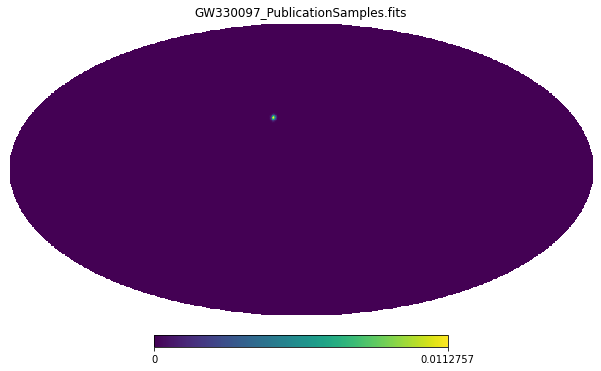

In [28]:
hp.mollview(p_posterior, title=GWs[98],nest=True)

Ligo area_deg 99% is 20.405326749196494
Ligo area_deg 90% is 10.228891301011096 
256


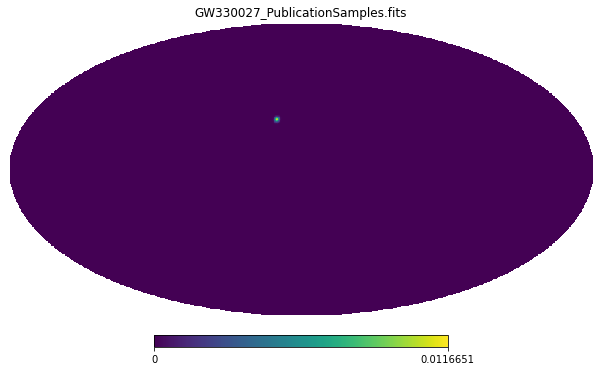

In [32]:
hp.mollview(p_posterior, title=GWs[56],nest=True)
credible_levels = find_greedy_credible_levels(p_posterior)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))
print(nside)

In [30]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(p_posterior))
my_ra, my_dec=find_ra_dec(nside,np.argmax(p_posterior))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(mu,weights=p_posterior)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(sigma,weights=p_posterior)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
Norm_avr=np.average(posteriorNorm,weights=p_posterior)
print('average posteriorNorm={}'.format(Norm_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

GW location: theta=1.1121794481956586, phi=0.32213596545598466, RA=18.45703125, DEC=26.27681155719998
average luminosity distance=8956.669910354267 Mpc
average luminosity distance Sigma=891.5533441876415 Mpc
average posteriorNorm=1.0
redshift=1.2469678532257413, in flagship cosmology
comoving distance=3986.113952407505


In [ ]:
_read_O3(GWs[0])

In [ ]:
phi_gals[14]

In [ ]:
for fname in tqdm(GWs):
    #print(fname)
    skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
    p_posterior= skymap[0]
    mu= skymap[1]
    sigma = skymap[2]
    posteriorNorm= skymap[3]        
    npix = len(p_posterior)
    nside=hp.npix2nside(npix)
    #alldl.append(mu[np.argmax(p_posterior)])
    #print('Dl={}'.format(mu[np.argmax(p_posterior)]))
    sigma=mu*0.1
    #sig=np.average(sigma,weights=p_posterior)
    #dl=np.average(mu,weights=p_posterior)
    #newdl=np.random.normal(dl,sig)
    #scale=newdl/dl
    #new_mu=scale*mu
    #new_sigma=new_mu*0.1
    #sig_avr=np.average(sigma,weights=p_posterior)
    #print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
    dat=Table([p_posterior,mu,sigma,posteriorNorm],
             names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)

In [ ]:
print(sigma[sigma>0])
np.shape(sigma)
print(len(p_posterior),len(sigma))



# List Creator to config.py

In [ ]:
names=[]

for i in range(306):
    numevent=int(990000)+i
    fname="'"+'GW'+str(numevent)+"'"
    names.append(fname)
    if (i % 38== 0)&(i>0):
        to_print=','.join(names)
        print('{}'.format(to_print))
        names=[]

In [ ]:
names=[]

for i in range():
    numevent=int(970000)+i
    fname="'"+'GW'+str(numevent)+"'"
    names.append(fname)
    to_print=','.join(names)
print('{}'.format(to_print))

In [ ]:
names=[]

for i in range(50):
    numevent=int(37)+i
    fname="'"+'GW'+str(numevent)+'0'+"'"
    names.append(fname)
    to_print=','.join(names)
print('{}'.format(to_print))

# Reset
those lines are used to reset the maps to the Datasheet state

In [ ]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [ ]:
#-------------------DATASHEET--------------------------------------
name='GW31xxxx_datasheet.txt'
#file= open(name,'w')
#my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
#file.writelines(my_header)
#file.close()
with open(name,'r') as f:
    next(f)
    lines=f.readlines()
    GWs_dl=[]
    GWs_theta=[]
    GWs_phi=[]
    GWs_z=[]
    GWs_deltadl=[]
    for x in lines:
        GWs_dl.append(float(x.split('\t')[1]))
        GWs_theta.append(float(x.split('\t')[2]))
        GWs_phi.append(float(x.split('\t')[3]))
        GWs_z.append(float(x.split('\t')[4]))
        GWs_deltadl.append(float(x.split('\t')[5]))
    #for i in range(len(GW_z)):

GWs_dl=np.asarray(GWs_dl)
GWs_theta=np.asarray(GWs_theta)
GWs_phi=np.asarray(GWs_phi)
GWs_z=np.asarray(GWs_z)
GWs_deltadl=np.asarray(GWs_deltadl)

In [ ]:
for i in tqdm(range(len(GWs_dl))):
    numevent=int(310000)+i
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=GWs_z[i]
    DS_phi=GWs_phi[i]
    DS_theta=GWs_theta[i]
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    if fisher==1:
        gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    else:
        gaussmap =np.zeros(len(p_posterior))
     #-------------inizialising some arrays------------   
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)

    dlref=GWs_dl[i]#cosmoflag.luminosity_distance(zref).value
    dlsig=0.01*dlref
    #print(zref,dlref)
    #line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
    #     str(dlsig)+'\t',str(sigma_phi)+'\n']

    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
    #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]

    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)
    #with open(name,'a') as f:
    #    f.writelines(line)

In [ ]:
fisher=1
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)

phi_min=0.0001
phi_max=1.5707961320877075
theta_min=0.0001976218846182377
theta_max=1.570796275052059
phi_start=phi_min+5*sigma_phi
phi_stop=phi_max-5*sigma_phi
step =5* sigma_phi
N=np.floor((phi_stop-phi_start)/step)
N=int(N)
#----------------------uniform in comoving DS-----------------------------
zlen=10
allredshift=np.zeros(zlen)
my_zmin=1.1
my_zmax=1.3
my_dcom_min=cosmoflag.comoving_distance(my_zmin).value
my_dcom_max=cosmoflag.comoving_distance(my_zmax).value
alldcom=np.linspace(my_dcom_min,my_dcom_max,zlen)
for i in range(zlen):
    allredshift[i]=z_from_dcom(alldcom[i])
#-------------------------------------------------------------------------
print('Sigma_theta={}, Sigma_phi={}'.format(sigma_theta,sigma_phi))
print('Sigma_theta={}°, Sigma_phi={}°'.format(np.rad2deg(sigma_theta)
                                              ,np.rad2deg(sigma_phi)))
print(step, N)
allphi=np.arange(0,N)*step+phi_start


truethetamin=theta_min+6*sigma_theta
truethetamax=theta_max-6*sigma_theta
M=np.floor((truethetamax-truethetamin)/step)
M=int(M)
alltheta=np.arange(0,M)*step+truethetamin


In [ ]:
allredshift=np.linspace(1.1,1.3,10)
fisher=1
if fisher==1:
    radius_deg= np.sqrt(1000/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    #conc=100
    #sigma_phi=np.sqrt(1/conc)
    #sigma_theta=sigma_phi
    radius_rad=np.radians(circle_deg)
for k in tqdm(range(1)):
    numevent=int(220000)+k
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=allredshift[k]
    #print(zref)
    DS_phi=np.pi/4
    DS_theta=np.pi/4
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))

    dlref=cosmoflag.luminosity_distance(zref).value
    dlsig=0.01*dlref
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\n']
    
    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        #mod_postnorm[i]=1/(mygaussint(mod_mu[i],mod_sigma[i]))
    #gaussmap[ipix_disc] = 1/len(ipix_disc)
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=1/(len(ipix_disc))
    mod_postnorm[ipix_disc]=1
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)
    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    #fits.write_sky_map(fname,dat, nest=True)
   # with open(name,'a') as f:
    #    f.writelines(line)

In [ ]:
hp.mollview(gauss64, title=fname,nest=True)

# Map for Minimal Example

In [ ]:
#----------------Load the catalogue---------------------
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
galcat = pd.read_csv('genova_uniform_samezasminimal.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
galcat.columns=colnames
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [ ]:
phi_min=0
phi_max=phi_min+5.5*sigma_phi
theta_min=0
theta_max=theta_min+5.5*sigma_theta#depends on the arccos 0 to 1 is from pi/2 to 0 -1 to 1 is full range
DS_phi=(phi_max-phi_min)/2
DS_theta=(theta_max-theta_min)/2

In [ ]:
#----------------------select random hosts ----------------------------------
zmin=0.1
zmax=0.3
#ra_min=np.rad2deg(DS_phi-1*sigma_phi)
#ra_max=np.rad2deg(DS_phi+1*sigma_phi)

#dec_max=np.rad2deg(0.5 * np.pi - (DS_theta-1*sigma_theta))
#dec_min=np.rad2deg(0.5 * np.pi - (DS_theta+1*sigma_theta))

Numb_of_DS=2
source=galcat[galcat['z']>=zmin]
source=source[source['z']<=zmax]
#source=source[source['declination_degrees']<=dec_max]
#source=source[source['declination_degrees']>=dec_min]
#source=source[source['right_ascension_degrees']<=ra_max]
#source=source[source['right_ascension_degrees']>=ra_min]

source=source.sample(n=Numb_of_DS)


#Best would be to remove the selected one, make them host and then add those again, 
#since we are converting coordinates
#pd.concat([df1, df2, df2]).drop_duplicates(keep=False)

DS_z=np.asarray(source['z'])
DS_dl=np.asarray(source['dl'])
DS_RA=np.asarray(source['right_ascension_degrees'])
DS_DEC=np.asarray(source['declination_degrees'])

phi_gals=np.deg2rad(DS_RA)
theta_gals = (0.5 * np.pi - np.deg2rad(DS_DEC))
#ra_gals=ra = np.rad2deg(phi_gals)
#dec_gals = np.rad2deg(0.5 * np.pi - theta_gals)

#checkRA=DS_RA-ra_gals
#chackDEC=DS_DEC-dec_gals
#print(checkRA)
#print(chackDEC)
fisher=0
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)
#-------------------DATASHEET--------------------------------------
name='GW98xxxx_datasheet.txt'
file= open(name,'w')
my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
file.writelines(my_header)
file.close()

In [ ]:
#--------------------Maps Generations-------------------------------
'''Use this when phi and theta both changes'''
for i in tqdm(range(Numb_of_DS)):
    numevent=int(980000)+i
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=DS_z[i]
    DS_phi=phi_gals[i]
    DS_theta=theta_gals[i]
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    if fisher==1:
        gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    else:
        gaussmap =np.zeros(len(p_posterior))
     #-------------inizialising some arrays------------   
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)

    dlref=DS_dl[i]#cosmoflag.luminosity_distance(zref).value
    dlsig=0.1*dlref
    #print(zref,dlref)
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\t',str(sigma_phi)+'\n']

    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        #gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
    #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]

    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)
    with open(name,'a') as f:
        f.writelines(line)

# Testing the distributions

In [ ]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [ ]:
fname ='GW960000_PublicationSamples.fits'
alldl=[]
allsig=[]
print(fname)
skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
p_posterior= skymap[0]
mu= skymap[1]
sigma = skymap[2]
posteriorNorm= skymap[3]        
npix = len(p_posterior)
print('npix={}'.format(npix))
nside=hp.npix2nside(npix)
print('nside={}'.format(nside))
theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
print('RA={},dec={},theta={},phi={}'.format(ra,dec,theta,phi))
alldl.append(mu[np.argmax(p_posterior)])
print('Dl={}'.format(mu[np.argmax(p_posterior)]))
sig_avr=np.average(sigma,weights=p_posterior)
allsig.append(sig_avr)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
allni=np.average(posteriorNorm,weights=p_posterior)
print('average N_i={}'.format(allni))
#print(len(p_posterior))
#alldl=np.asarray(alldl)
#print(np.mean(alldl))

# Single Map

In [56]:
@njit
def sphere_uncorr_gauss_vec(x_vec,mu_vec,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    meanvec=mu_vec
    norm=np.sqrt(np.sum(meanvec**2))
    meanvec=meanvec/norm

    var=x_vec
    norm=np.sqrt(np.sum(var**2))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.sum(diff**2))

    norm=np.sqrt(1/(2*np.pi*sigy*sigy))**3
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))/norm

    return ret

100%|████████████████████████████████████████████████████████████████| 59741/59741 [00:02<00:00, 23251.55it/s]


Ligo area_deg 99% is 201.6927541148085
Ligo area_deg 90% is 100.84637705740425 
512


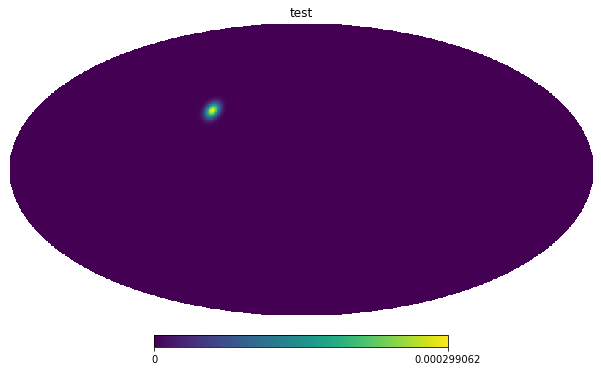

In [66]:
radius_deg= np.sqrt(100/np.pi)
sigma90=radius_deg/np.sqrt(2)
sigma_deg=sigma90/1.511#*(np.sqrt(2)/3)#sigma90/1.511#1.6448536269514
circle_deg=6*sigma_deg
sigma_theta=np.radians(sigma_deg)
sigma_phi=np.radians(sigma_deg)
radius_rad=np.radians(circle_deg)

nside=512#1024#512
npix = hp.nside2npix(nside)
DS_phi=np.pi/3
DS_theta=np.pi/3
vec = hp.ang2vec(DS_theta, DS_phi)
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
#print(DS_theta,DS_phi)

gaussmap =np.zeros(npix)
 #-------------inizialising some arrays------------   
mod_mu=np.zeros(len(gaussmap))
mod_sigma=np.zeros(len(gaussmap))
mod_postnorm=np.zeros(len(gaussmap))
theta_arr=np.zeros(len(gaussmap))
phi_arr=np.zeros(len(gaussmap))
gauss128 =np.zeros(len(gaussmap),dtype=np.float128)
ref_vec=hp.ang2vec(DS_theta,DS_phi)
ref_norm=np.sqrt(np.sum(ref_vec**2))
ref_vec=ref_vec/ref_norm

for i in tqdm(ipix_disc):
    theta,phi=hp.pix2ang(nside,i, nest=True)
    theta_arr[i]=theta
    phi_arr[i]=phi
    my_vec=hp.ang2vec(theta,phi)
    vec_norm=np.sqrt(np.sum(my_vec**2))
    my_vec=my_vec/vec_norm
    #gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
    gaussmap[i]=sphere_uncorr_gauss_vec(my_vec,ref_vec,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
    #gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
#print(np.sum(gaussmap))
hp.mollview(gaussmap, title='test',nest=True)
credible_levels = find_greedy_credible_levels(gaussmap)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))
print(nside)

In [37]:
1/(np.sqrt(2)*1.511)

0.4679727208382181

In [61]:
t =np.random.uniform(-1,1,1_000_000)
Omega_90=50
radius_deg= np.sqrt(Omega_90/np.pi)
sigma90=radius_deg/np.sqrt(2)
sigma_deg=sigma90/(1.511*1)#1.6448536269514
circle_deg=6*sigma_deg
sigma_theta=np.radians(sigma_deg)
sigma_phi=np.radians(sigma_deg)
radius_rad=np.radians(circle_deg)
k=1/sigma_phi**2
y=np.exp(t*k*(1-t**2)**(1/2))

In [ ]:
hp.nside2pixarea(nside, degrees=True)

# Using Covariance

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pickle
from tqdm import tqdm

from astropy.table import Table
from ligo.skymap.io import fits
import os
from os import listdir
from os.path import isfile, join

In [ ]:
fname ='GWtest00.fits'
print(fname)
LigoData, metadata = fits.read_sky_map(fname, nest=True, distances=True)
p_posterior= LigoData[0]
mu= LigoData[1]
sigma = LigoData[2]
posteriorNorm= LigoData[3]        
Ligonpix = len(p_posterior)
Ligonpixnside=hp.npix2nside(Ligonpix)
hp.mollview(p_posterior, title=fname,nest=True)

In [2]:
def _get_credible_region_pth(p_posterior,level=0.9):
    '''
    Finds value minskypdf of rho_i that bouds the x% credible region , with x=level
    Then to select pixels in that region: self.all_pixels[self.p_posterior>minskypdf]
    '''
    prob_sorted = np.sort(p_posterior)[::-1]
    prob_sorted_cum = np.cumsum(prob_sorted)
    # find index of array which bounds the self.area confidence interval
    idx = np.searchsorted(prob_sorted_cum, level)
    minskypdf = prob_sorted[idx] #*skymap.npix

    #self.p[self.p]  >= minskypdf       
    return minskypdf

def get_credible_region_pixels(all_pixels, p_posterior, level=0.9):

    return all_pixels[p_posterior>_get_credible_region_pth(p_posterior,level=level)]

100%|███████████████████████████████████████████████████████████████████████| 488/488 [00:04<00:00, 98.23it/s]


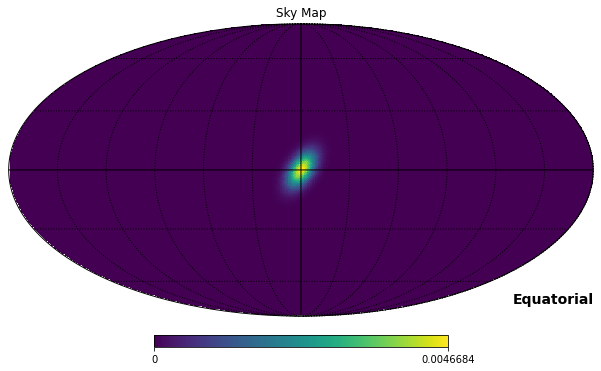

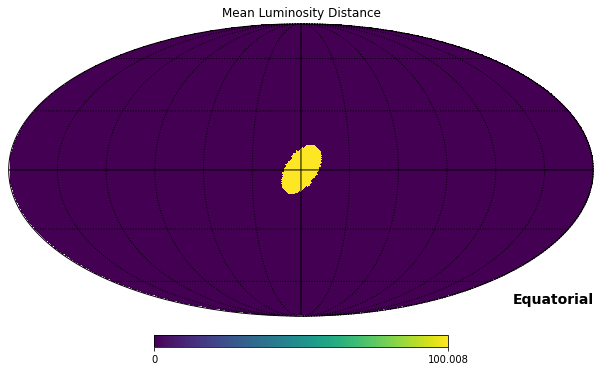

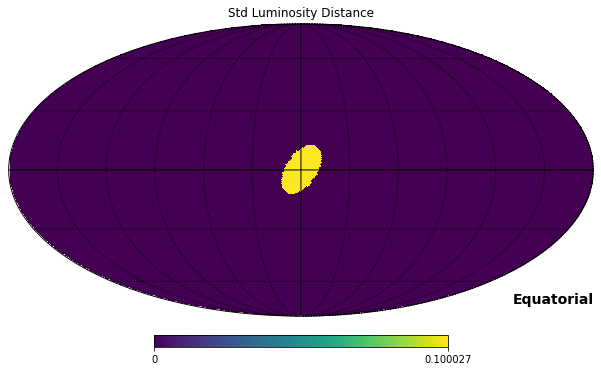

In [3]:
# Parameters for the multivariate Gaussian distribution
mean = [0, np.pi/2, 100]  # Mean of the distribution i.e. from catalogue
cov = np.array([[0.01, 0.005, -0.0003], 
                [0.005, 0.01, 0.0002], 
                [-0.0003, 0.0002, 0.01]])  # Covariance matrix from GWfast

# Number of samples
num_samples = 5_000_000
samples = np.random.multivariate_normal(mean, cov, num_samples)

# Extract phi, theta
phi = samples[:, 0]
theta = samples[:, 1]
luminosity_distance = samples[:, 2]
# Ensure theta is within the range [0, π]
theta = np.mod(theta, np.pi)

# Number of pixels in the sky map
nside = 64
npix=hp.nside2npix(nside)
all_pixels=np.arange(npix)
# Convert phi and theta to the format used by HEALpy
theta_hp = theta
phi_hp = np.mod(phi, 2 * np.pi)  # Ensure phi is within the range [0, 2π]

# Create a HEALPix map
sky_map = np.zeros(hp.nside2npix(nside))
pixels = hp.ang2pix(nside, theta_hp, phi_hp)
# Increment the pixel values
np.add.at(sky_map, pixels, 1)
sky_map = sky_map / np.sum(sky_map)

# Get the array of good pixels where sky_map > 0 and 90%
good_pix = np.where(sky_map > 0)[0]
pix90=get_credible_region_pixels(all_pixels,sky_map)
# arrays to store the mean and std of luminosity distance
all_mu = np.zeros(hp.nside2npix(nside))
all_std = np.zeros(hp.nside2npix(nside))

# dictionary to store new luminosity distance arrays for each pixel, maybe will be useful
luminosity_distance_samples = {}

# Number of new samples to generate for each pixel
new_samples_per_pixel = 600_000

def process_pixel(pix):
    if sky_map[pix] > 0:
        # Get the fixed theta and phi for this pixel
        theta_fixed, phi_fixed = hp.pix2ang(nside, pix)
        
        # Create a new mean vector with the fixed theta and phi
        new_mean = np.array([phi_fixed, theta_fixed, mean[2]])
        
        # Partition the covariance matrix
        Sigma_xx = cov[:2, :2]
        Sigma_xy = cov[:2, 2]
        Sigma_yx = cov[2, :2]
        Sigma_yy = cov[2, 2]
        
        # Compute the conditional mean and covariance
        mu_cond = mean[2] + Sigma_yx @ np.linalg.inv(Sigma_xx) @ (np.array([phi_fixed, theta_fixed]) - mean[:2])
        Sigma_cond = Sigma_yy - Sigma_yx @ np.linalg.inv(Sigma_xx) @ Sigma_xy
        
        # Sample from the conditional Gaussian distribution
        new_samples = np.random.normal(mu_cond, np.sqrt(Sigma_cond), new_samples_per_pixel)
        
        # Extract the new luminosity distances
        new_luminosity_distance = new_samples
        
        # Compute the mean and std of the luminosity distance
        mu = np.mean(new_luminosity_distance)
        std = np.std(new_luminosity_distance)
        
        return pix, mu, std, new_luminosity_distance
    return pix, None, None, None

num_processors = 10

with Pool(processes=num_processors) as pool:
    # Using tqdm to add a progress bar
    results = list(tqdm(pool.imap(process_pixel, pix90), total=len(pix90)))
    
#with Pool(processes=num_processors) as pool:
#    results = pool.map(process_pixel, good_pix)

# Collect the results
for pix, mu, std, new_luminosity_distance in results:
    if mu is not None and std is not None:
        all_mu[pix] = mu
        all_std[pix] = std
        luminosity_distance_samples[pix] = new_luminosity_distance

# Plot the sky map
hp.mollview(sky_map, title="Sky Map", coord=['C'])
hp.graticule()
plt.show()

# Plot the mean luminosity distance map
hp.mollview(all_mu, title="Mean Luminosity Distance", coord=['C'])
hp.graticule()
plt.show()

# Plot the std luminosity distance map
hp.mollview(all_std, title="Std Luminosity Distance", coord=['C'])
hp.graticule()
plt.show()

#with open('luminosity_distance_samples.pkl', 'wb') as f:
#    pickle.dump(luminosity_distance_samples, f)


244


(array([1.56354077e-05, 1.68080633e-04, 1.48536373e-03, 1.04600877e-02,
        5.24997902e-02, 2.03444016e-01, 6.17348437e-01, 1.44323803e+00,
        2.60323284e+00, 3.63010388e+00, 3.92838055e+00, 3.28397113e+00,
        2.13010931e+00, 1.06697977e+00, 4.14385210e-01, 1.24618108e-01,
        2.79834709e-02, 4.98378620e-03, 7.81770385e-04, 7.03593346e-05]),
 array([ 99.47275076,  99.52391668,  99.5750826 ,  99.62624852,
         99.67741444,  99.72858036,  99.77974628,  99.8309122 ,
         99.88207811,  99.93324403,  99.98440995, 100.03557587,
        100.08674179, 100.13790771, 100.18907363, 100.24023955,
        100.29140546, 100.34257138, 100.3937373 , 100.44490322,
        100.49606914]),
 <BarContainer object of 20 artists>)

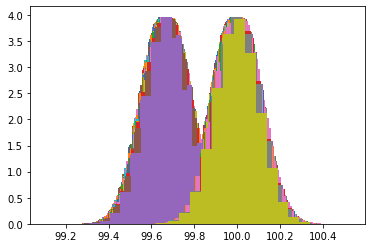

In [4]:
print(int(len(pix90)/2))
for pix in pix90 :
    plt.hist(luminosity_distance_samples.get(pix),bins=20,density=True)
plt.hist(luminosity_distance,bins=20,density=True)

Now we try to save this as a skymap

In [6]:
mod_postnorm=np.ones(len(sky_map))
fname='GWtest00.fits'
dat=Table([sky_map,all_mu,all_std,mod_postnorm],
      names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
fits.write_sky_map(fname,dat, nest=False)
#with open(fname,'a') as f:
#    f.writelines(line)

In [ ]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/Hold_O3/'
#os.chdir(GW_data_path)